In [1]:
%matplotlib inline
import seaborn as sns # pretty plots

In [37]:
import pymc3 as pm  # fork of pymc-devs/pymc master from https://github.com/aflaxman/pymc
import numpy as np
from pymc3 import model_to_graphviz, Continuous, Discrete
import arviz as az

In [29]:
from pymc3.theanof import floatX
import theano.tensor as tt

In [42]:
class Constant(Discrete):
    def __init__(self, **kwargs): 
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(1))
        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        return 1
    
    def logp(self, value):
        return 0

In [43]:
with pm.Model() as model:
    A = Constant('A')
    B = pm.Normal('B', mu=20+A, sd=10)

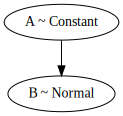

In [44]:
model_to_graphviz(model)

In [46]:
with model:
    pm.sample(1000, ninit=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [A]
>NUTS: [B]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3084.93draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


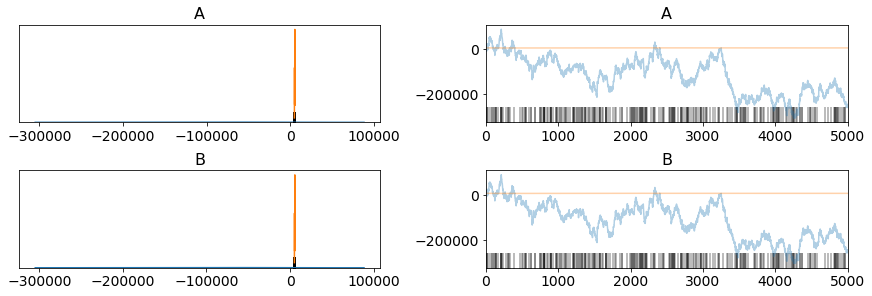

In [47]:
az.plot_trace(trace);